# Transfer Learning with TensorFlow Part 3: Scaling up (🍔👁️ Food Vision mini)

We've seen the power of transfer learning feature extracion and fine-tuning, now it's time to scale up to all of the classes in Food101 (101 total classes of food).

Our goal is to beat the original Food101 paper with 10% of the training data (leveraging the power of deep learning).

Our baseline to beats is 50.76% accuracy across 101 classes.

## Creating helper functions

In [ ]:
# Get helper_functions.py script from GitHub
!wget https://raw.githubusercontent.com/GusTiavo123/deep-learning/main/helper_functions.py

# Import helper functions we're going to use
from helper_functions import create_tensorboard_callback, unzip_data, walk_through_dir, plot_loss_curves

In [42]:
import sys
from contextlib import contextmanager

# Define a context manager to temporarily add a path to sys.path
@contextmanager
def temporary_sys_path_append(path):
    sys.path.append(path)  # Add the specified path to sys.path
    try:
        yield  # Allow code within the with-block to execute
    finally:
        # Ensure the path is removed after exiting the with-block
        sys.path.remove(path)

# Using the context manager to temporarily add a path to sys.path
with temporary_sys_path_append('..'):
    # Inside this block, you can import modules located in the added path
    from helper_functions import create_tensorboard_callback, unzip_data, walk_through_dir, plot_loss_curves, compare_historys, make_confusion_matrix
    # Use the function or perform actions with the imported module here

# Outside the with-block, the path is no longer in sys.path, limiting the change to the block

In [11]:
import tensorflow as tf
import logging
tf.get_logger().setLevel(logging.ERROR)

## 101 Food Classes working with less data

Our goal is to beat the original Food101 paper with 10% of the training data, so let's download it.

The data we're downloading comes from the original Food101 dataset but has been preprocessed using the [image_data_modification](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb) notebook 

In [ ]:
# Download 10% 101 Food classes
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

In [4]:
unzip_data("101_food_classes_10_percent.zip")

In [2]:
train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

In [5]:
# How many images/classes are there?
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent\test'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\apple_pie'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\baby_back_ribs'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\baklava'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\beef_carpaccio'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\beef_tartare'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\beet_salad'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\beignets'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\bibimbap'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\bread_pudding'.
There are 0 directories and 250 images in '10

In [3]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) # don't suffle test data for prediction analysis

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big dog model with transfer learning 10% of 101 food classes

Here are the steps we're going to take
* Create a ModelCheckpoint callback
* Create a data augmentation layer to build data augmentation right into the model
* Build a headless (no top layer) Functional EfficientNetB0 backboned-model (we'll create our own output layer)
* Compile our model
* Feature extract for 5 full passes (5 epochs on the train dataset and validation on 15% of the test data, to save epoch time)

In [4]:
# Create checkpoint callback
checkpoint_path = "101_food_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_best_only=True,
                                                         monitor="val_accuracy",
                                                         save_weights_only=True)

In [7]:
# Create data augmentation layer to incorporate it rigth into the model
from tensorflow.keras import layers
from tensorflow.keras import Sequential

# Setup data augmentation
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    layers.RandomZoom(0.2)
], name="data_augmentation")

In [9]:
# Create backbone model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False) # put the base model in inference mode so weights that need to stay frozen will stay the same
x = layers.GlobalAveragePooling2D(name="global_avg_pooling")(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x)

# Create model
model_1 = tf.keras.Model(inputs, outputs)

In [12]:
# Compile the model
model_1.compile(optimizer=tf.keras.optimizers.Adam(),
                loss="categorical_crossentropy",
                metrics=["accuracy"])

# Fit the model
history_all_classes_10_percent = model_1.fit(train_data_all_10_percent,
                                             epochs=5,
                                             steps_per_epoch=len(train_data_all_10_percent),
                                             validation_data=test_data,
                                             validation_steps=int(0.15 * len(test_data)),
                                             callbacks=[checkpoint_callback])

Epoch 1/5


237/237 [==============================] - 194s 772ms/step - loss: 3.3629 - accuracy: 0.2749 - val_loss: 2.4820 - val_accuracy: 0.4592
Epoch 2/5
237/237 [==============================] - 169s 715ms/step - loss: 2.2038 - accuracy: 0.4965 - val_loss: 2.0537 - val_accuracy: 0.5117
Epoch 3/5
237/237 [==============================] - 175s 739ms/step - loss: 1.8212 - accuracy: 0.5686 - val_loss: 1.9060 - val_accuracy: 0.5217
Epoch 4/5
237/237 [==============================] - 180s 758ms/step - loss: 1.5861 - accuracy: 0.6210 - val_loss: 1.7924 - val_accuracy: 0.5389
Epoch 5/5
237/237 [==============================] - 167s 705ms/step - loss: 1.4437 - accuracy: 0.6411 - val_loss: 1.8048 - val_accuracy: 0.5294


In [13]:
feature_extract_results = model_1.evaluate(test_data)

790/790 [==============================] - 401s 507ms/step - loss: 1.5939 - accuracy: 0.5795


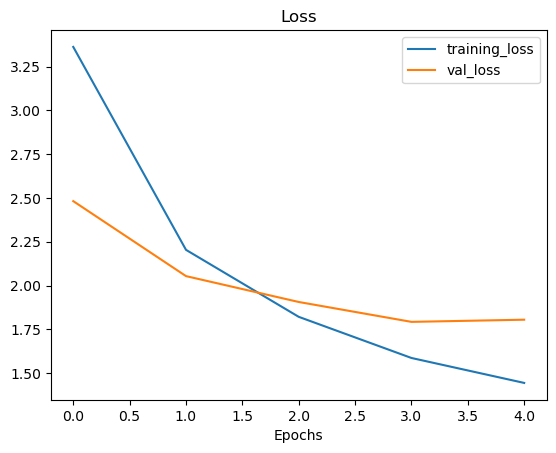

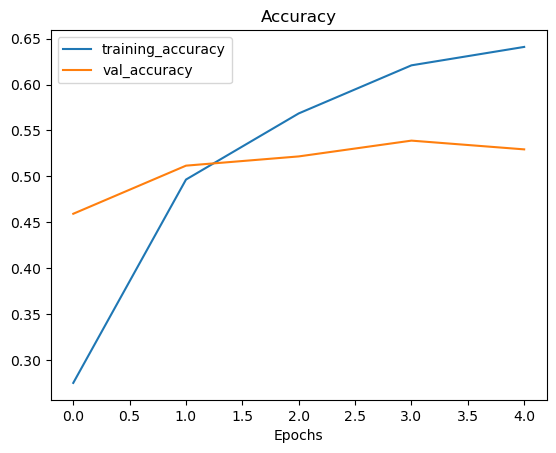

In [14]:
plot_loss_curves(history_all_classes_10_percent)

Our model is overfitting (performing too well on the training data and not generalizinf to unseen data)

## Fine-tuning

In [15]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except the last 5
for layer in base_model.layers[:-5]:
    layer.trainable = False

In [16]:
# Recompile the model
model_1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                loss="categorical_crossentropy",
                metrics=["accuracy"])

In [17]:
# What layers in the model are trainable?
for layer in model_1.layers:
    print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_avg_pooling True
output_layer True


In [22]:
# Check wich layers are trainable in our base model
for layer_number, layer in enumerate(model_1.layers[2].layers):
    print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze False
39

In [24]:
# Load checkpoint
model_1.load_weights("101_food_classes_10_percent_data_model_checkpoint")

# Set initial epochs
initial_epochs = 5

In [26]:
# Fit the model for 5 epochs more
fine_tuning_epochs = initial_epochs + 5

fine_tuning_history = model_1.fit(train_data_all_10_percent,
                                  epochs=fine_tuning_epochs,
                                  steps_per_epoch=len(train_data_all_10_percent),
                                  initial_epoch=history_all_classes_10_percent.epoch[-1],
                                  validation_data=test_data,
                                  validation_steps=int(0.15 * len(test_data)))

Epoch 5/10


237/237 [==============================] - 213s 900ms/step - loss: 1.4976 - accuracy: 0.6022 - val_loss: 1.7358 - val_accuracy: 0.5469
Epoch 6/10
237/237 [==============================] - 214s 904ms/step - loss: 1.0322 - accuracy: 0.7127 - val_loss: 1.7961 - val_accuracy: 0.5474
Epoch 7/10
237/237 [==============================] - 207s 874ms/step - loss: 0.7568 - accuracy: 0.7836 - val_loss: 1.9534 - val_accuracy: 0.5236
Epoch 8/10
237/237 [==============================] - 200s 843ms/step - loss: 0.5915 - accuracy: 0.8253 - val_loss: 1.8905 - val_accuracy: 0.5461
Epoch 9/10
237/237 [==============================] - 179s 754ms/step - loss: 0.4355 - accuracy: 0.8673 - val_loss: 2.1927 - val_accuracy: 0.5201
Epoch 10/10
237/237 [==============================] - 216s 910ms/step - loss: 0.3587 - accuracy: 0.8957 - val_loss: 2.1120 - val_accuracy: 0.5424


In [27]:
# Evaluate on the whole test data
fine_tuning_results = model_1.evaluate(test_data)
fine_tuning_results

790/790 [==============================] - 375s 474ms/step - loss: 1.9145 - accuracy: 0.5737


[1.9145183563232422, 0.5737425684928894]

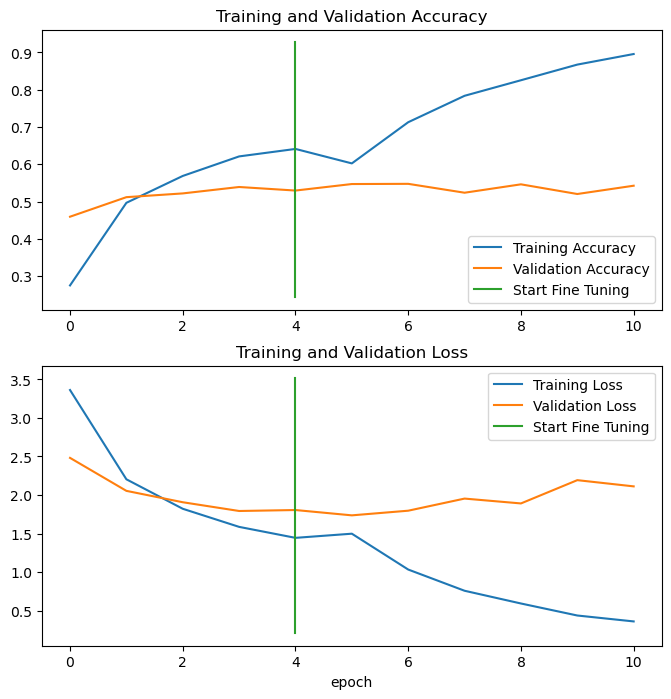

In [28]:
# Compare the histories of feature extraction and fine-tuning
compare_historys(history_all_classes_10_percent,
                 fine_tuning_history,
                 5)

## Evaluating the performance of the big dog model across all different classes

Let's make some predictions, visualize them and then later find out wich predictions were the "most" wrong.

In [33]:
# Make predictions with model
pred_probs = model_1.predict(test_data, verbose=1) # set verbosity to see how long is left

790/790 [==============================] - 406s 512ms/step


In [34]:
# How many predictions are there?
len(pred_probs)

25250

In [35]:
# What does the first prediction probability look like?
pred_probs[0], len(pred_probs[0]), sum(pred_probs[0]), pred_probs[0].argmax(), test_data.class_names[pred_probs[0].argmax()]

(array([8.2574613e-02, 5.0617913e-08, 7.7065878e-02, 1.6198401e-12,
        1.9527948e-07, 7.8712675e-10, 6.2554903e-07, 8.4047471e-08,
        1.2155254e-03, 4.1671688e-06, 7.4821415e-08, 1.5572290e-09,
        9.7477023e-05, 4.2246773e-10, 3.1768381e-05, 5.6333978e-05,
        8.8387459e-08, 3.6053450e-06, 2.8431162e-04, 7.5028339e-08,
        3.0527182e-05, 4.7032835e-08, 4.7681758e-07, 7.3571027e-07,
        3.5873734e-06, 4.0323252e-05, 3.1156167e-06, 4.4314966e-06,
        1.8271211e-03, 4.3445591e-05, 6.6966005e-10, 4.3617253e-04,
        9.6209355e-05, 2.7911472e-11, 5.2884154e-02, 6.5904473e-08,
        6.9316457e-08, 2.5013671e-07, 6.0002905e-05, 8.7842972e-07,
        1.7258330e-06, 6.9444231e-06, 8.5154460e-07, 1.0803942e-06,
        3.0205890e-06, 1.7032653e-06, 1.9140369e-05, 1.7813878e-06,
        3.6601233e-10, 5.4426346e-04, 8.7828562e-07, 1.1510124e-07,
        5.4370578e-02, 1.1466689e-03, 4.5599265e-08, 4.5156046e-03,
        3.6187796e-06, 1.7436057e-04, 6.4382902e

Our model outputs a prediction probability array (with N number of variables, where N is the number of classes) for eachsample passesd to the predict method.

In [36]:
# Get the pred classes of each label
pred_classes = pred_probs.argmax(axis=1)
pred_classes[:10]

array([86, 57,  0,  0,  2,  8, 29, 58,  2,  0], dtype=int64)

Now we've got a predictions array of all of our model's predictions, to evaluate them, we need to compare them to the original test dataset labels.

In [37]:
test_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 101), dtype=tf.float32, name=None))>

In [38]:
# To get our test labels we need to unravel our test_data BatchDataset
y_labels = []
for images, labels in test_data.unbatch():
    y_labels.append(labels.numpy().argmax())
y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

## Evaluating our model's predictions

One way to check that our model's predictions array is in the same order as our test labels array is to find the accuracy score.

In [39]:
fine_tuning_results

[1.9145183563232422, 0.5737425684928894]

In [41]:
# Let's try scikit-learn's accuracy score function and see what it comes up with
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels,
                                  pred_classes)
sklearn_accuracy

0.5737425742574257

## Let's get visual: making a confusion matrix

In [44]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=test_data.class_names,
                      figsize=(100,100),
                      text_size=20)

## Let's keep the evaluation train going, time for a classification report

Scikit-learn has a helpful function for acquiring many different classification metrics per class (e.g. precision, recall and F1) called `classification_report`, let's try it out.

In [45]:
from sklearn.metrics import classification_report
print(classification_report(y_labels,
                            pred_classes))

              precision    recall  f1-score   support

           0       0.27      0.25      0.26       250
           1       0.63      0.59      0.61       250
           2       0.71      0.62      0.66       250
           3       0.85      0.38      0.53       250
           4       0.48      0.58      0.53       250
           5       0.55      0.46      0.50       250
           6       0.70      0.81      0.75       250
           7       0.78      0.82      0.80       250
           8       0.23      0.63      0.33       250
           9       0.68      0.38      0.49       250
          10       0.61      0.36      0.46       250
          11       0.82      0.54      0.65       250
          12       0.63      0.64      0.64       250
          13       0.49      0.56      0.52       250
          14       0.49      0.56      0.52       250
          15       0.62      0.10      0.17       250
          16       0.76      0.50      0.60       250
          17       0.32    

In [46]:
# Get a dictionary of the classification report
classification_dictionary = classification_report(y_labels,
                                                  pred_classes,
                                                  output_dict=True)
classification_dictionary

{'0': {'precision': 0.26609442060085836,
  'recall': 0.248,
  'f1-score': 0.25672877846790887,
  'support': 250},
 '1': {'precision': 0.625531914893617,
  'recall': 0.588,
  'f1-score': 0.6061855670103092,
  'support': 250},
 '2': {'precision': 0.7129629629629629,
  'recall': 0.616,
  'f1-score': 0.6609442060085836,
  'support': 250},
 '3': {'precision': 0.8495575221238938,
  'recall': 0.384,
  'f1-score': 0.5289256198347108,
  'support': 250},
 '4': {'precision': 0.48494983277591974,
  'recall': 0.58,
  'f1-score': 0.5282331511839709,
  'support': 250},
 '5': {'precision': 0.5450236966824644,
  'recall': 0.46,
  'f1-score': 0.49891540130151846,
  'support': 250},
 '6': {'precision': 0.7,
  'recall': 0.812,
  'f1-score': 0.7518518518518519,
  'support': 250},
 '7': {'precision': 0.7803030303030303,
  'recall': 0.824,
  'f1-score': 0.801556420233463,
  'support': 250},
 '8': {'precision': 0.22655122655122656,
  'recall': 0.628,
  'f1-score': 0.3329798515376458,
  'support': 250},
 '9': 

Let's plot all of our classes F1-scores...

In [47]:
# Create empty dictionary
class_f1_scores = {}
# Loop through classification report dictionary items
for k, v in classification_dictionary.items():
    if k == "accuracy":
        break
    else:
        # Add class names and f1-scores to new dictionary
        class_f1_scores[test_data.class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'apple_pie': 0.25672877846790887,
 'baby_back_ribs': 0.6061855670103092,
 'baklava': 0.6609442060085836,
 'beef_carpaccio': 0.5289256198347108,
 'beef_tartare': 0.5282331511839709,
 'beet_salad': 0.49891540130151846,
 'beignets': 0.7518518518518519,
 'bibimbap': 0.801556420233463,
 'bread_pudding': 0.3329798515376458,
 'breakfast_burrito': 0.4884318766066838,
 'bruschetta': 0.455,
 'caesar_salad': 0.6521739130434783,
 'cannoli': 0.6361829025844931,
 'caprese_salad': 0.5186567164179104,
 'carrot_cake': 0.5186567164179104,
 'ceviche': 0.1660899653979239,
 'cheese_plate': 0.6024096385542169,
 'cheesecake': 0.4059701492537314,
 'chicken_curry': 0.5023696682464455,
 'chicken_quesadilla': 0.5736434108527131,
 'chicken_wings': 0.6754098360655737,
 'chocolate_cake': 0.4603960396039604,
 'chocolate_mousse': 0.36711281070745705,
 'churros': 0.7599999999999999,
 'clam_chowder': 0.5570776255707761,
 'club_sandwich': 0.6846473029045643,
 'crab_cakes': 0.4256410256410257,
 'creme_brulee': 0.7298969

In [54]:
# Turn f1-socres into dataframe for visualization
import pandas as pd
f1_scores = pd.DataFrame({"class_names": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=True)

Text(0.5, 1.0, 'F1-scores for 101 different food classes (predicted by food vision mini)')

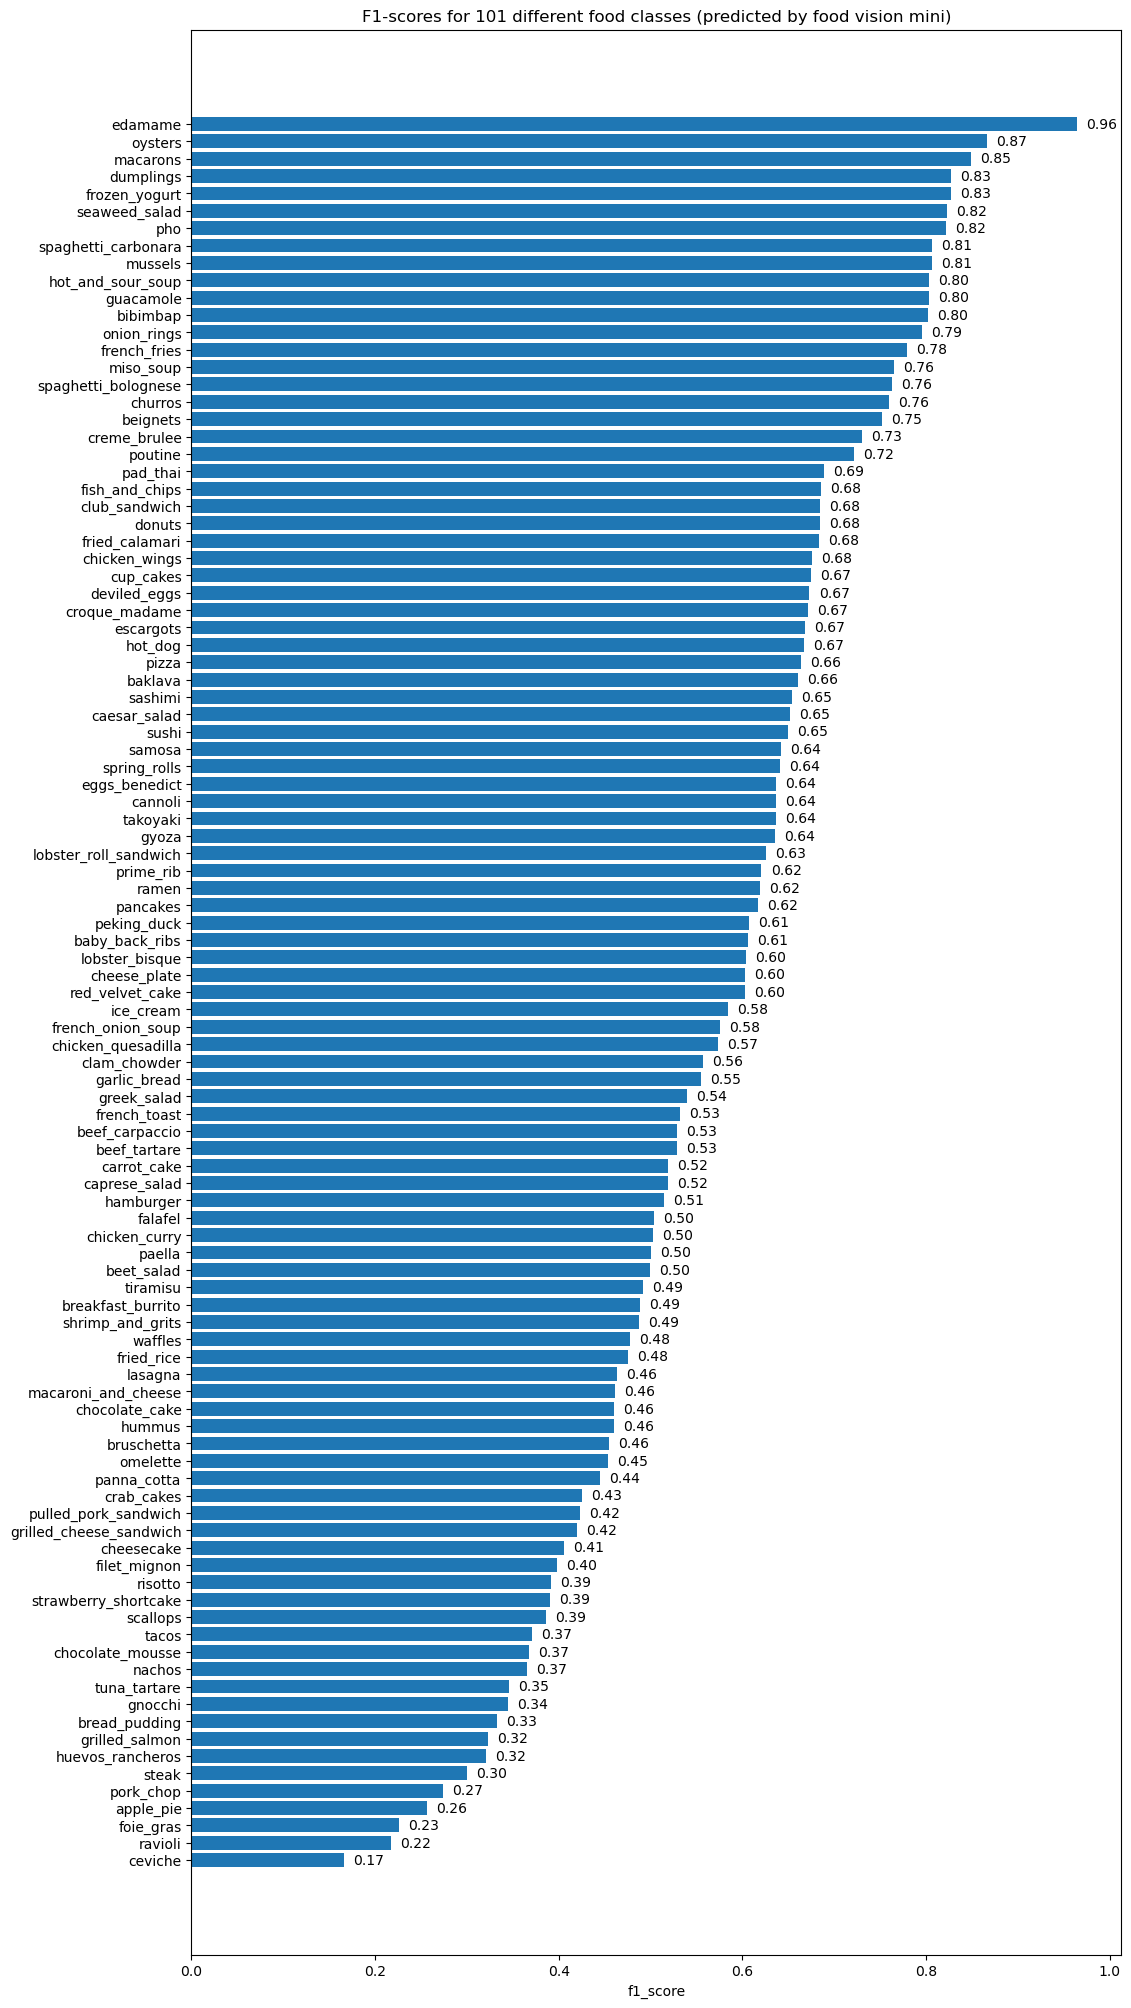

In [56]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)


for bar in scores:
    width = bar.get_width()  
    label_x_pos = width + 0.01  
    ax.text(label_x_pos, bar.get_y() + bar.get_height()/2., f'{width:.2f}', 
            va='center')

ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"])
ax.set_xlabel("f1_score")
ax.set_title("F1-scores for 101 different food classes (predicted by food vision mini)")



## Visualizing predictions on custom images

To visualize our model's predictions on our own images, we'll need a function to load and preprocess images, specifically it will need to:
* Read in a target image filepath using `tf.io.read_file()`
* Turn the image into a Tensor using `tf.io.decode_imgae()`
* Resize the image tensor to be the same size as the images our model has trainded on using `tf.image.resize()`
* Scale the image to get all of the pixel values between 0 & 1 (if necessary)


In [57]:
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).

  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.io.decode_image(img, channels=3)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

1/1 [==============================] - 0s 63ms/step


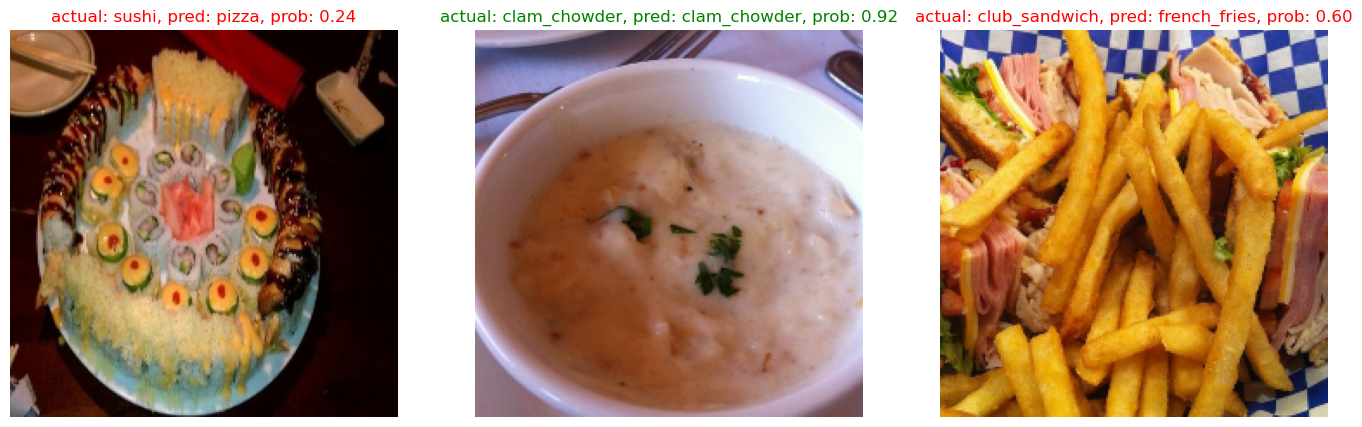

In [61]:
# Make preds on a series of random images
import os
import random

plt.figure(figsize=(17, 10))
for i in range(3):
    class_name = random.choice(test_data.class_names)
    filename = random.choice(os.listdir(test_dir + "/" + class_name))
    filepath = test_dir + class_name + "/" + filename

    img = load_and_prep_image(filepath, scale=False)
    pred_prob = model_1.predict(tf.expand_dims(img, axis=0))
    pred_class = test_data.class_names[pred_prob.argmax()]

    plt.subplot(1, 3, i+1)
    plt.imshow(img/255.)
    if class_name == pred_class:
        title_color = "g"
    else:
        title_color = "r"
    plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
    plt.axis(False)

In [65]:
# 1. Get the filenames of all of our test data
filepaths = []
for filepath in test_data.list_files("101_food_classes_10_percent/test/*/*.jpg", shuffle=False):
    filepaths.append(filepath.numpy())

filepaths[:10]

[b'101_food_classes_10_percent\\test\\apple_pie\\1011328.jpg',
 b'101_food_classes_10_percent\\test\\apple_pie\\101251.jpg',
 b'101_food_classes_10_percent\\test\\apple_pie\\1034399.jpg',
 b'101_food_classes_10_percent\\test\\apple_pie\\103801.jpg',
 b'101_food_classes_10_percent\\test\\apple_pie\\1038694.jpg',
 b'101_food_classes_10_percent\\test\\apple_pie\\1047447.jpg',
 b'101_food_classes_10_percent\\test\\apple_pie\\1068632.jpg',
 b'101_food_classes_10_percent\\test\\apple_pie\\110043.jpg',
 b'101_food_classes_10_percent\\test\\apple_pie\\1106961.jpg',
 b'101_food_classes_10_percent\\test\\apple_pie\\1113017.jpg']

In [67]:
# 2. Create a dataframe out of current prediction data for analysis
import pandas as pd
pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": pred_probs.max(axis=1), # get the maximum prediction probability value
                        "y_true_classname": [test_data.class_names[i] for i in y_labels],
                        "y_pred_classname": [test_data.class_names[i] for i in pred_classes]}) 
pred_df.head()
     

img_path  y_true  y_pred  \
0  b'101_food_classes_10_percent\\test\\apple_pie...       0      86   
1  b'101_food_classes_10_percent\\test\\apple_pie...       0      57   
2  b'101_food_classes_10_percent\\test\\apple_pie...       0       0   
3  b'101_food_classes_10_percent\\test\\apple_pie...       0       0   
4  b'101_food_classes_10_percent\\test\\apple_pie...       0       2   

   pred_conf y_true_classname y_pred_classname  
0   0.696490        apple_pie          sashimi  
1   0.860397        apple_pie           hummus  
2   0.826210        apple_pie        apple_pie  
3   0.204355        apple_pie        apple_pie  
4   0.528634        apple_pie          baklava

In [68]:
# 3. Is the prediction correct?
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

img_path  y_true  y_pred  \
0  b'101_food_classes_10_percent\\test\\apple_pie...       0      86   
1  b'101_food_classes_10_percent\\test\\apple_pie...       0      57   
2  b'101_food_classes_10_percent\\test\\apple_pie...       0       0   
3  b'101_food_classes_10_percent\\test\\apple_pie...       0       0   
4  b'101_food_classes_10_percent\\test\\apple_pie...       0       2   

   pred_conf y_true_classname y_pred_classname  pred_correct  
0   0.696490        apple_pie          sashimi         False  
1   0.860397        apple_pie           hummus         False  
2   0.826210        apple_pie        apple_pie          True  
3   0.204355        apple_pie        apple_pie          True  
4   0.528634        apple_pie          baklava         False

In [69]:
# 4. Get the top 100 wrong examples
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong.head(20)

img_path  y_true  y_pred  \
5596   b'101_food_classes_10_percent\\test\\chocolate...      22      60   
17855  b'101_food_classes_10_percent\\test\\paella\\2...      71      65   
10374  b'101_food_classes_10_percent\\test\\french_on...      41      60   
6237   b'101_food_classes_10_percent\\test\\clam_chow...      24      60   
18383  b'101_food_classes_10_percent\\test\\panna_cot...      73      60   
4809   b'101_food_classes_10_percent\\test\\chicken_q...      19      76   
10329  b'101_food_classes_10_percent\\test\\french_on...      41      76   
5624   b'101_food_classes_10_percent\\test\\chocolate...      22      60   
23520  b'101_food_classes_10_percent\\test\\strawberr...      94      17   
15826  b'101_food_classes_10_percent\\test\\macarons\...      63      29   
3509   b'101_food_classes_10_percent\\test\\carrot_ca...      14      29   
14977  b'101_food_classes_10_percent\\test\\lasagna\\...      59      24   
7858   b'101_food_classes_10_percent\\test\\donuts\\2...      31       6   
6184   b'101_food_classes_10_percent\\test\\clam_chow...      24      60   
6038   b'101_food_classes_10_percent\\test\\clam_chow...      24      60   
4583   b'101_food_classes_10_percent\\test\\chicken_c...      18      60   
7295   b'101_food_classes_10_percent\\test\\cup_cakes...      29      31   
6131   b'101_food_classes_10_percent\\test\\clam_chow...      24      60   
23539  b'101_food_classes_10_percent\\test\\strawberr...      94      83   
14907  b'101_food_classes_10_percent\\test\\lasagna\\...      59      76   

       pred_conf      y_true_classname y_pred_classname  pred_correct  
5596    0.999997      chocolate_mousse   lobster_bisque         False  
17855   0.999993                paella          mussels         False  
10374   0.999990     french_onion_soup   lobster_bisque         False  
6237    0.999987          clam_chowder   lobster_bisque         False  
18383   0.999987           panna_cotta   lobster_bisque         False  
4809    0.999984    chicken_quesadilla            pizza         False  
10329   0.999978     french_onion_soup            pizza         False  
5624    0.999960      chocolate_mousse   lobster_bisque         False  
23520   0.999953  strawberry_shortcake       cheesecake         False  
15826   0.999952              macarons        cup_cakes         False  
3509    0.999939           carrot_cake        cup_cakes         False  
14977   0.999937               lasagna     clam_chowder         False  
7858    0.999931                donuts         beignets         False  
6184    0.999925          clam_chowder   lobster_bisque         False  
6038    0.999903          clam_chowder   lobster_bisque         False  
4583    0.999901         chicken_curry   lobster_bisque         False  
7295    0.999898             cup_cakes           donuts         False  
6131    0.999887          clam_chowder   lobster_bisque         False  
23539   0.999874  strawberry_shortcake  red_velvet_cake         False  
14907   0.999864               lasagna            pizza         False

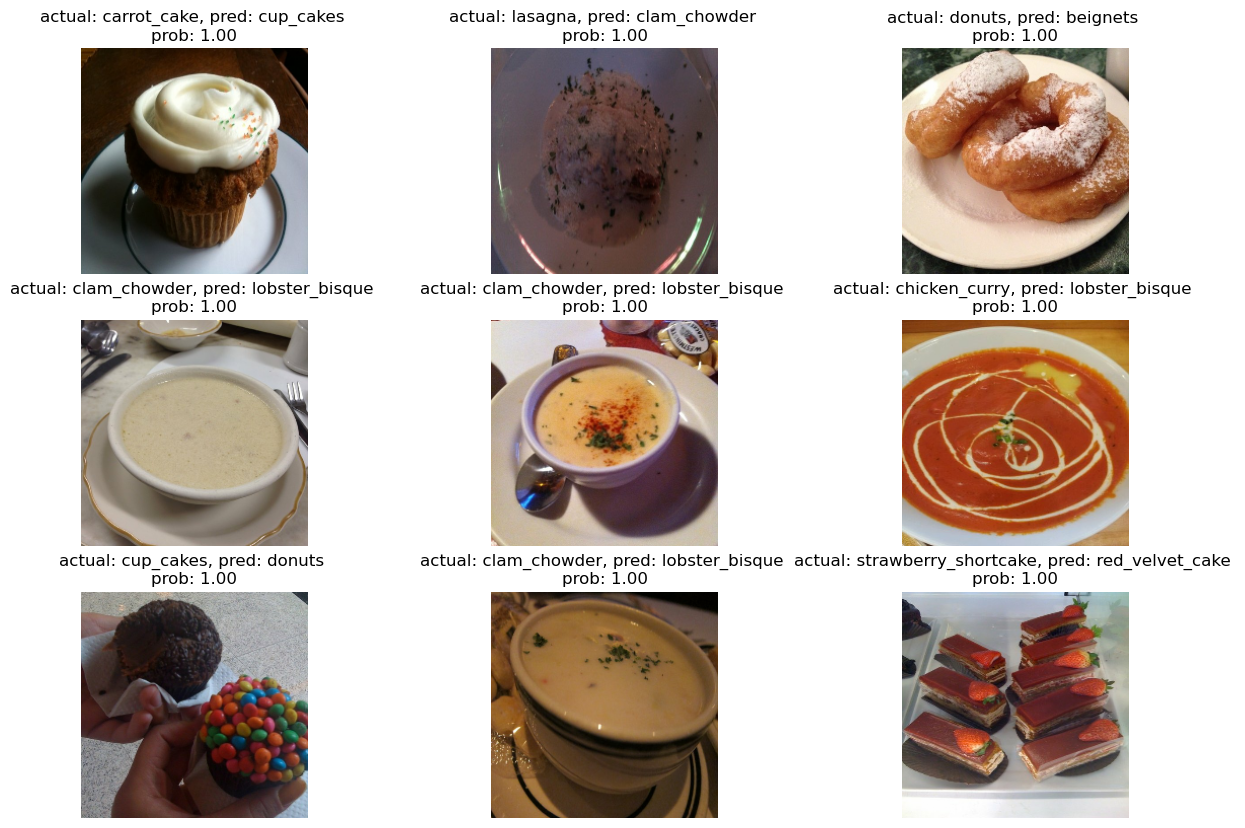

In [70]:
# 5. Visualize some of the most wrong examples
images_to_view = 9
start_index = 10 # change the start index to view more
plt.figure(figsize=(15, 10))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()): 
  plt.subplot(3, 3, i+1)
  img = load_and_prep_image(row[1], scale=True)
  _, _, _, _, pred_prob, y_true, y_pred, _ = row # only interested in a few parameters of each row
  plt.imshow(img)
  plt.title(f"actual: {y_true}, pred: {y_pred} \nprob: {pred_prob:.2f}")
  plt.axis(False)